<a href="https://colab.research.google.com/github/fipaniagua/IIC3697-Deep-Learning/blob/develop/DQN%20for%20Breakout%20with%20Pytorch/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3: Deep Reinforcement Learning
Francisco Paniagua

En esta tarea se implemenetara el algoritmo de DQN (deep Q learning) mediante la implementaciín de OpenAi Gym, Mas una red neuroanl convolucional implementada mediante pytorch

## Set-up

En esta sección se instalara las librerias necesaria para poder visualizar el resultado mediante un video mp4. Esta sección se puede ignorar si no se quiere revisar los detalles del setup del monitor (wraper del env para visualizar el juego)

In [ ]:
!pip install pyvirtualdisplay
!pip install piglet
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
from gym.wrappers import Monitor
from IPython.display import HTML
from IPython import display as ipythondisplay
import base64
import glob
import io

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  #if len(mp4list) > 0:
  for mp4 in mp4list:  
    #mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Actividad 1

A continuación se implementaran wrapper **levemente** modificados del repositorio https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py para poder realizar el preprocesamiento de las observaciones.
Este preprocesamiento consiste en los siguientes


1.   Episode Life Env: Este preprocesamiento consiste transformar done = true al final de la perdida de cada vida. y reiniciar el juego **solo si** se acaban todas las vidas
1.   Fire reset Env: Este preprocesamiento manda la acción "fire" al reiniciaar el juego (lo cual permite empezar el juego de inmediato)
1.   WarpFrame: Este preprocesamiento transforma la dimension a 84x84x1, es decir, cambia los colores a solo un canal de grises
1. MaxAndSkip Env: Este preprocesamiento permite saltar cada 2 frames y tomar un frame que considere el maximo de ambos frames tomados
1. FrameStack: luego de hacer el maxandskip se juntan 4 frames (8 frames en total) 


¿Por qué usamos los últimos 4 pasos como input de la red, para jugar Breakout? (4 pasos ya habiendo hecho max-pooling, serían 8 cuadros originales).

* El max-pooling se usa para que cada estado tenga toda la información necesaria, ya que, elenvarioment puede entregar estados en donde la bolita no salga.
* Luego es necesario hacer el FrameStack (tomar 4 estados), ya que esto permitira que el agente pueda inferir desde el estado, información sobre la dirección y velocidad de la bola.


### Episode Life Env


In [ ]:
from gym import spaces
import numpy as np
import cv2
import gym
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Fire reset Env

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        print("ocurrio un reset")
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

### WarpFrame

In [ ]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        """
        super().__init__(env)
        self._width = 84
        self._height = 84
        num_colors = 1

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        original_space = self.observation_space
        self.observation_space = new_space

        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        frame = obs
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        frame = np.expand_dims(frame, -1)
        obs = frame
        return obs

### MaxAndSkip Env

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = 2

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break 
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

### FrameStack

In [ ]:
from collections import deque
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self.get_np_frames()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self.get_np_frames(), reward, done, info

    def get_np_frames(self):
        return np.concatenate(list(self.frames), axis=-1)




### Wrap Final Combinado

In [ ]:
def wrap_env(env):
  env = EpisodicLifeEnv(env)
  #env = Monitor(env, './video', force=True)
  env = FireResetEnv(env)  
  env = WarpFrame(env)
  env = MaxAndSkipEnv(env)
  env = FrameStack(env, 4)
  
  return env

## Actividad 2

### Experience Replay memory

In [ ]:
from collections import namedtuple



class ExperienceReplay(object):
    
    def __init__(self, capacity, device):
        c,h,w = (4, 84, 84)
        self.capacity = capacity
        self.device = device
        self.m_states = torch.zeros((capacity, c, h, w), dtype=torch.uint8, device=device)
        self.m_next_states = torch.zeros((capacity, c, h, w), dtype=torch.uint8, device=device)
        self.m_actions = torch.zeros((capacity, 1),  dtype=torch.long, device=device)
        self.m_rewards = torch.zeros((capacity, 1),  dtype=torch.int8, device=device)
        self.m_dones = torch.zeros((capacity, 1), dtype=torch.bool, device=device)
        self.position = 0
        self.size = 0
        self.last_state = torch.zeros((capacity, c ,h ,w))

    def push(self, state, action, next_state, reward, done):
        self.m_states[self.position] = state
        self.last_state = next_state
        self.m_next_states[self.position] = next_state
        self.m_actions[self.position,0] = action
        self.m_rewards[self.position,0] = reward
        self.m_dones[self.position,0] = done
        self.position = (self.position + 1) % self.capacity
        self.size = max(self.size, self.position)
    
    def get_last_state(self):
      return self.last_state
      
    def sample(self, batch_size):
        pick_vector = torch.randint(0, high=self.size, size=(batch_size,))
        batch_state = self.m_states[pick_vector].to(self.device) 
        batch_next_state = self.m_next_states[pick_vector].to(self.device) 
        ba = self.m_actions[pick_vector].to(self.device)
        br = self.m_rewards[pick_vector].to(self.device).float()
        bd = self.m_dones[pick_vector].to(self.device).float()
        return batch_state, ba, br, batch_next_state, bd

    def __len__(self):
        return self.size

### CNN aproximadora del valor Q

In [ ]:
from torch import nn
import torch

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[2], 32, kernel_size=8, stride=4),   #input_shape = (84,84,4) EJ f(x) = 3*x[0] + x[2]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = 64*7*7
        #conv_out_size es tamaño de salida de redes convolucionales
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def forward(self, input):
        conv_out = self.conv(input)
        #print(conv_out.shape) [batch size, 64 , 7 , 7]
        x = conv_out.view(-1, self.num_flat_features(conv_out))
        x = self.fc(x)
        #print(x.shape) [batch size, 4]
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features    

### Exploración e-greedy

In [ ]:
import random
class Agent:

  def __init__(self, env, replay_memory):
    self.env = env
    self.replay_memory = replay_memory
    self.lives_played = 0
    self.score = []
    self.episode_reward = 0

  def play_step(self, net, epsilon, device):
     random_pick = random.random()
     state = self.replay_memory.get_last_state()
     if random_pick < epsilon:
       #random step
       print("random step")
       action = random.randint(0,3)
       next_state, reward, done, info = self.env.step(action)

     else:
       #greedy step  
       print("greedy step")
       obs = torch.stack([state])
       predictions = net(obs.float())
       #print(predictions)
       action = torch.argmax(predictions[0]).item()
       #print(action)
       next_state, reward, done, info = self.env.step(action)
     
     next_state_tensor = torch.tensor(next_state, device=device)
     next_state_tensor = next_state_tensor.transpose(0 ,2)
     self.episode_reward += reward
     #print(info, reward, action) 
     self.replay_memory.push(state, action, next_state_tensor, reward, done)
     if done: 
      self.score.append(self.episode_reward)
      self.env.reset()
      self.lives_played += 1 
      if self.lives_played % 5 == 0: #un juego completo consta de 5 vidas
        self.episode_reward = 0
     return reward 

In [ ]:
def  epsilon_strategy(EPSILON_FINAL, EPSILON_START, EPSILON_STEPS_DECAY, step):
    if step > EPSILON_STEPS_DECAY:
      return EPSILON_FINAL
    else:
      r = step/EPSILON_STEPS_DECAY
      return EPSILON_START - (EPSILON_START - EPSILON_FINAL)*r


### Función de entrenamiento

In [ ]:
def calculate_loss(batch, net, target_net, criterion, device):
    #print(type(batch))
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
    #print(f"sb: {state_batch.shape} ab: {action_batch.shape} ns: {next_state_batch.shape} done_batch: {done_batch.shape}")
    predictions = net(state_batch.float()).gather(1, action_batch)
    next_q_prediction = target_net(next_state_batch.float()).max(1)[0].detach()

    expected_value = reward_batch[:,0] + (next_q_prediction * GAMMA)*(1. - done_batch[:,0])  
    #print(predictions.shape, "p")
    #print(expected_value.unsqueeze(1).shape, "e")
    return criterion(predictions, expected_value.unsqueeze(1))

In [ ]:
REPLAY_SIZE = 80000
BATCH_SIZE = 32
EPSILON_FINAL = 0.1
EPSILON_START = 1
EPSILON_STEPS_DECAY =  100000
STEPS_TO_TRAIN = 250000
LEARNING_STARTS = 50000
device = torch.device('cuda:0')
TARGET_UPDATE_FREQ = 5000
GAMMA = 0.99
EPOCS = 3

loss_values = []
criterion = torch.nn.MSELoss()
env = gym.make("Breakout-v0")
env = wrap_env(env)
net = DQN((84,84,4), 4).to(device)
target_net = DQN((84,84,4), 4).to(device)
replay_memory = ExperienceReplay(REPLAY_SIZE, device)
agent = Agent(env, replay_memory)
epsilon = EPSILON_START

optimizer = torch.optim.Adam(net.parameters())
step = 0

#parto jugando para tener el estado incial
state = env.reset()
obs = torch.tensor(state, device=device)
print(obs.shape, "*")
obs = obs.transpose(0, 2)
print(obs.shape, "**")
replay_memory.push(obs, 1, obs, 0, 0)

for epoc in range(EPOCS):
  for _ in range(STEPS_TO_TRAIN):
      step += 1
      epsilon = epsilon_strategy(EPSILON_FINAL, EPSILON_START, EPSILON_STEPS_DECAY, step)
      reward = agent.play_step(net, epsilon, device=device)
      print(f"epsilon: {epsilon}, step: {step}, reward: {reward}")

      # acá hay que graficar y registrar scores, lo pueden implementar dentro del agente

      if len(replay_memory) < LEARNING_STARTS:
          continue

      
      optimizer.zero_grad()
      batch = replay_memory.sample(BATCH_SIZE)
      loss_t = calculate_loss(batch, net, target_net, criterion, device)
      loss_values.append(loss_t.item())
      print(f"perdida: {loss_t.item()}")
      loss_t.backward()
      optimizer.step()

      if step % TARGET_UPDATE_FREQ == 0:
          target_net.load_state_dict(net.state_dict())

Se truncaron las últimas líneas 5000 del resultado de transmisión.
greedy step
epsilon: 0.1, step: 748345, reward: 0.0
perdida: 0.8552238345146179
greedy step
epsilon: 0.1, step: 748346, reward: 0.0
perdida: 0.09885489195585251
greedy step
epsilon: 0.1, step: 748347, reward: 0.0
perdida: 0.2916034758090973
greedy step
epsilon: 0.1, step: 748348, reward: 0.0
perdida: 0.1368621289730072
greedy step
epsilon: 0.1, step: 748349, reward: 0.0
perdida: 0.14814090728759766
greedy step
epsilon: 0.1, step: 748350, reward: 0.0
perdida: 0.3309866189956665
greedy step
epsilon: 0.1, step: 748351, reward: 0.0
perdida: 0.21036730706691742
greedy step
epsilon: 0.1, step: 748352, reward: 1.0
perdida: 0.19540610909461975
greedy step
epsilon: 0.1, step: 748353, reward: 0.0
perdida: 0.1657133400440216
greedy step
epsilon: 0.1, step: 748354, reward: 0.0
perdida: 0.1632206290960312
greedy step
epsilon: 0.1, step: 748355, reward: 0.0
perdida: 0.16486769914627075
greedy step
epsilon: 0.1, step: 748356, reward: 

In [ ]:
print("vidas jugadas:", agent.lives_played)
print("largo memoria:", len(replay_memory))

vidas jugadas: 19421
largo memoria: 79999


## Actividad 3

### Experience replay


La experience replay memory permite ir almacenando la información que nuestro agente a visto durante la exploración, especificamente tuplas de la forma:



```
et = (state_t, action_t, next_state_t, reward_t, done_t)
```

De tal forma de poder samplear de forma aleatoria estas "experiencias" al momento de actualizar nuestra red. esto permite dos ventajas claves:



*   Eliminar la **correlación existente entre sampleos consecutivos**, permitiendo hacer una red entrenada de forma mas robusta
*   Entrenar la red con varios ejemplos a la vez, de tal forma de acelerar el entrenamiento




### e-greedy strategy




<img src="https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png" alt="drawing" width="500"/>

Bajo el algoritmo de e-greedy, nuestro agente se enfrenta a la encrucijada de que accione tomar. Para resolver esto, lo que se hace es usar un aproach no deterministico. En donde con un probabilidad epsilon se elige aleatoriamente o se explota el conocimiento que se tiene hasta el momento.

En nuestro caso, como en un principio no tenemos casi nada de conocimiento, es conveninte explorar el espacio de acciones mediante una estrategia aleatoria, por esta razón se usa un epsilon de 1, sin embargo a medida que vamos entrenando nuestro modelo, vamos aprendiendo y progesivamente podemos usar esta información para elegir la acción a usar.

Por esta razon el valor de epsilon va disminullendo hasta llegar a un valor minimo. Usamos un valor minimo y no cero porque de vez en cuando queremos tomar una acción distinta a la que pensamos que es la mejor, para no quedar atascados en minimos locales

## Actividad 4

A continnuación se presenta una tabla con todos los hiper-parametros usados con su valor y descripción


Hiper-parametro | Descripción | valor usado
--|--|--|
REPLAY_SIZE | cantidad de pasos almacenados| 80000
BATCH_SIZE | cantidad de pasos usados para hacer backpropagation | 32
EPSILON_FINAL | epsilon al cual se llega en la estrategia e-greddy | 0.1
EPSILON_START  |  epsilon con cual se parte en la estratefia e-greddy | 1
EPSILON_STEPS_DECAY | cantidad de pasos hasta llegar al valor de epsilon final |  100000
STEPS_TO_TRAIN | pasos usados por epoca |250000
LEARNING_STARTS | numero de pasos en los cuales se comienzo el entrenamiento  |  50000
device | procesador usado | 'cuda:0'
TARGET_UPDATE_FREQ | cada cuantos pasos se actualiza la red hermana| 5000
GAMMA | valor ocupado en la formala de Q | 0.99
EPOCS | cantidad de epocas para el entrenamiento |  3
STATE SIZE | tamaño de la codificación del estado del juego | 2x84x84



## Actividad 5


Para calcular la cantidad de parametros del modelo, implementaremos una funcion que nos permitira revisarlo directamente desde el objeto.

In [ ]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

Para el caso en donde existe preprocesamiento (i.g 84x84x4)

In [ ]:
con_preprocesamiento = DQN((84, 84, 3),4)
params = num_trainable_parameters(con_preprocesamiento)
print(f"Parametros con preprocesamiento: {params}")

Parametros con preprocesamiento: 1684132


Para el caso en donde no existe preprocesamiento (i.g. 210, 160, 12)

In [ ]:
con_preprocesamiento = DQN((210, 160, 12),4)
params = num_trainable_parameters(con_preprocesamiento)
print(f"Parametros con preprocesamiento: {params}")

Parametros con preprocesamiento: 1702564


Podemos notar que la cantidad de parametros no aumenta demasiado (18432 parametros mas), esto se deve a que los filtros de las convoluciones van a mantener su tamaño y por tanto la cantidad de parametro, es decir, los unicos parametros que aumentan son las capas finals lineales.

Esto no implica que el tiempo de procesamiento se mantenga parecido, ya que la cantidad de operaciones aumentara considerablemente devido a que los filtros tendran que pasar por un input de mayor tamaño

## Actividad 6

A continuación podemos obserbar la media movil de 100 episodios (5 vidas) a lo largo de todo el entrenamiento. Asombrosamente podemos observar que nuestro agente **si** esta aprendiendo, a pesar, de que existe una gran variación, se puede notar que la tendencia es a aumentar el puntaje.  

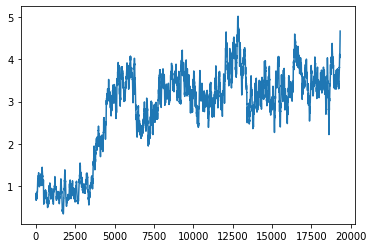

In [ ]:
import matplotlib.pyplot as plt

#plt.plot(agent.score)
#plot.show()

avgscores = [sum(agent.score[i-100: i])/len(agent.score[i-100: i])   for i in range(100, len(agent.score)) ]
plt.plot(avgscores)

Por el contrario cuando observamos la perdida, se puede notar un movimiento muy errático y no se ve una clara tendencia a disminuir. Esto tiene muchisimo sentido, ya que, a medida que va aprendiendo, tambien va aprendiendo a etiquetar mejor, y por tanto se el error nuevo que obtiene, es un error mas cercano a la realidad, de esta forma, este error puede ir aumentando, ya que cada vez se da cuenta con mayor presición de lo mal que esta prediciendo. 

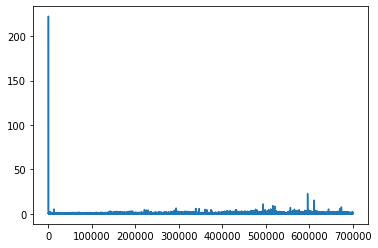

In [ ]:
plt.plot(loss_values)